# Predicting the Number of Bike Rentals using Decision Tree and Random Forest

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [90]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
print(bike_rentals.shape)
bike_rentals.head()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Text(0.5,0,'Count')

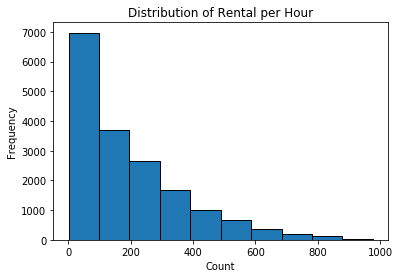

In [91]:
bike_rentals['cnt'].plot.hist(edgecolor="black") #total number of bike rental, casual + registered
plt.title("Distribution of Rental per Hour")
plt.xlabel("Count")

In [92]:
bike_rentals.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

In order to better classify our feauture, instead of each hour, we do a categorical classification of the time of rental in a each, with the data being: morning, afternoon, evening, past-midnight.

In [93]:
#convert hour at rental to categorical like:1,2,3,4 (morning, afternoon,evening,night)
def assign_label(row):
    if (row >=6) and (row <12):
        return 1 #le matin
    elif (row >=12) and (row <18):
        return 2 #l'apres midi
    elif (row >=18) and (row < 24):
        return 3 #evening
    elif (row >=0) and (row < 6):
        return 4 #la soiree
    return

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [94]:
bike_rentals.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


In [95]:
#we then split the train/test set to 80/20
train = bike_rentals.sample(frac=0.7)
temp_index = bike_rentals.index.isin(train.index) #retrieving indices of our train set
test = bike_rentals.iloc[~temp_index] #not in index

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
features = list(bike_rentals.columns)
features.remove("cnt") #our target
#these are the columns that 'cnt' is derived from. 
#Different types of users who happen to rent bikes on that hour. They add up to'cnt' as we did before
cols = ['casual','dteday','registered']
for i in cols:
    features.remove(i)
    
def linear_model(bike_rentals,features):
    X_train, X_test, y_train, y_test = train_test_split(bike_rentals[features],bike_rentals["cnt"],test_size=0.8,random_state=1)
    model = LinearRegression()
    model.fit(train[features],train['cnt'])
    hypothesis = model.predict(test[features])

    mse = np.mean((test['cnt'] - hypothesis)**2)
    print(mse)
    print("Mean: ",test['cnt'].mean(),"Stdev: ",test['cnt'].std())
    return mse, hypothesis

mse1,lr1 = linear_model(bike_rentals,features)
print(lr1[:10])
print(test.cnt[:10])

17688.38369806537
Mean:  191.5759493670886 Stdev:  183.06301696500077
[-111.36023457  -85.32194881   64.46026182  141.48215269  130.60227426
  124.30736261  135.53500076   69.21137285   94.68539938   90.73455053]
1      40
3      13
6       2
10     36
15    110
16     93
17     67
18     35
21     34
22     28
Name: cnt, dtype: int64


That's quite a high error, given the fact that our mean is only 188 in the 'cnt' column of test. As we have seen, it's unreasonable that some of the lower values of test carry a negative prediction on such a high swing. Actually, this is understandable since the top 3 parameters with high correlation to "cnt" are actually ["casual","registered","temp"]. Most other parameters after that don't carry as much weight as those. Items such as "weekday", "month" are actually better off as categorical,yet these don't carry as much meaning in Linear Regression.

# Machine Learning Model #2: Decision Tree and Random Forest

In [97]:
#using decision tree to see if it's better than Linear Regression

from sklearn.tree import DecisionTreeRegressor
model2 = DecisionTreeRegressor(min_samples_leaf=8)
model2.fit(train[features],train['cnt'])

hypothesis2 = model2.predict(test[features])
mse2 = np.mean((test['cnt'] - hypothesis2)**2)
print(mse2)

2624.5111576149184


Decision tree seems to be a lot better than Linear Regression. This probably is because the model isn't linear. Then we would expect the decision forest to be better. Also, many of the data aren't continous and aren't meant to be used with Linear Regression. Let's see if Random Forest Regressor will work better also.

In [98]:
from sklearn.ensemble import RandomForestRegressor

model3 = RandomForestRegressor(min_samples_leaf = 8) #same type of trees
model3.fit(train[features],train['cnt'])

hypothesis3 = model3.predict(test[features])
mse3 = np.mean((test['cnt'] - hypothesis3)**2)
print(mse3)
print(mse3**0.5)

2285.4315081864606
47.806186923728404


Since a single tree is prone to overfitting, it's good to see how much more we could've improved with random forest, which are less prone to overfitting. Let's put it together and try to tune the hyperparameters of our RandomForestRegressor Model

In [99]:
from collections import OrderedDict

def rf_model(bike_rentals,features,min_leaf):
    global train, test
    result = OrderedDict()
    for i in range(1,min_leaf):
        model3 = RandomForestRegressor(min_samples_leaf=i) #same type of trees
        model3.fit(train[features],train['cnt'])
        
        hypothesis3 = model3.predict(test[features])
        metric = np.mean((test['cnt'] - hypothesis3)**2)
        result[i] = metric
    return result

rf = rf_model(bike_rentals, features,15)
rf

OrderedDict([(1, 1944.2768258534716),
             (2, 1950.0758227551992),
             (3, 1986.9561257900957),
             (4, 1995.2339741369362),
             (5, 2108.313476265857),
             (6, 2194.5987051412694),
             (7, 2219.7753213976303),
             (8, 2308.0814713479126),
             (9, 2349.368569968104),
             (10, 2482.6430089644628),
             (11, 2416.873318543116),
             (12, 2537.0109510204047),
             (13, 2565.538114418896),
             (14, 2547.3964700742054)])

Text(0,0.5,'MSE')

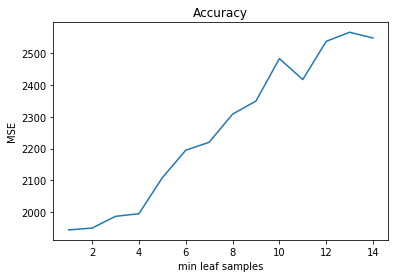

In [122]:
x = [i for i in range(1,15)]
y = []
for key in x:
    y.append(rf[key])
plt.plot(x,y)
plt.title("Accuracy")
plt.xlabel("min leaf samples")
plt.ylabel("MSE")

It is surprising that small number of min leaf samples does not give into overfitting. Seems like the minimum leaf samples is not a hyperparameter we should play with. Let's do a matrix Grid Search

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

rf = RandomForestRegressor()
#we'll play with: maximum features to split at a nodes, the number of trees, and the minimum samples leaf for pruning
hyper_params = { 'max_features':np.arange(1,10),'n_estimators':np.arange(5,15),'min_samples_leaf': np.arange(1,10)}
rf_grid = GridSearchCV(rf, hyper_params, cv = 5)
rf_grid.fit(train[features],train["cnt"])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [127]:
rf_grid.get_params()

{'cv': 5,
 'error_score': 'raise',
 'estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
 'estimator__bootstrap': True,
 'estimator__criterion': 'mse',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 10,
 'estimator__n_jobs': 1,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'fit_params': {

In [142]:
def rf_best(bike_rentals,features):    
    rf = RandomForestRegressor(min_samples_leaf=1, min_samples_split=2, n_estimators=10) 
    #doens't seem to be too different from the default
    rf.fit(train[features],train["cnt"])
    hypothesis = rf.predict(test[features])
    metric = np.mean((test['cnt'] - hypothesis)**2)
    return metric
metric = rf_best(bike_rentals,features)
print(metric, metric**0.5, test.cnt.mean())
print(hypothesis[:20])
print(test.cnt[:20])

2071.4604046797085 45.51329920671219 191.5759493670886
[ 23.8   8.7   3.5  86.2 118.8  80.7 129.4  74.6  51.1  54.8  44.   28.2
  19.8  59.4  56.4  94.2  78.8  81.8  91.1  10.9]
1      40
3      13
6       2
10     36
15    110
16     93
17     67
18     35
21     34
22     28
23     39
25     17
27      6
30      1
32     20
35     93
37     59
39     76
41     53
46      8
Name: cnt, dtype: int64


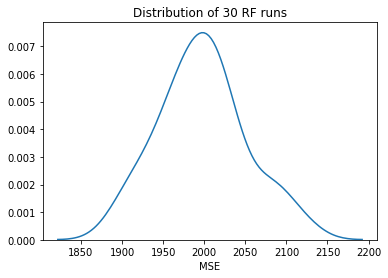

52.06626091386069 1997.5792438946426


In [151]:
#Let's observe the variance and distribution of the metric.
metric = []
for i in range(30):
    metric.append(rf_best(bike_rentals,features))

sns.kdeplot(metric)
plt.title("Distribution of 30 RF runs")
plt.xlabel("MSE")
plt.show()
print(np.std(metric), np.mean(metric))

Although the mean and stdev are roughly consistent (which is a good thing and doesn't seem to be overfitting), it is really interesting to see that our model doens't always give results in a manner close to a normal distribution. The mean MSE is about ~2000, which is not any meaningful improvement over our default model. However, it is greatly better than the Linear Regression.

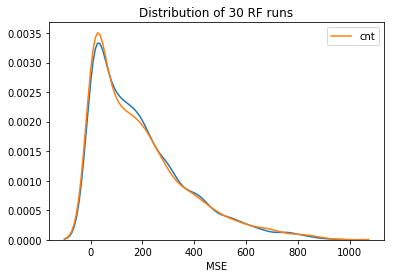

1.61752972765631 45.06470053094533


In [173]:
#let's plot our predictions out
sns.kdeplot(hypothesis)
sns.kdeplot(test['cnt'])
plt.title("Distribution of 30 RF runs")
plt.xlabel("MSE")
plt.show()

print(np.mean(hypothesis-test["cnt"]),np.std(hypothesis-test["cnt"]))

The mean value is pretty well off, and it's understandable that we have such a high standard deviation. As shown in the first plot of the distribution per hour rental, some data points are over hundreds of times - thus leaving our initial dataset highly varied.
machine learning is especially good for optimization but it's not a perfect way to predict outliers

# Machine Learning Model #3: SVM Regression